In [1]:
from research_env.misc.globals import *  # Project variables, paths to data, plotting utilities, etc.
from faculty_hiring.parse import load    # For loading DBLP records (CS)

NOTEBOOK_ID = 'MP_CS_PHD_' # Breadcrumbs for linking figures to notebooks

In [2]:
load.load_all_publications(cs_faculty, DBLP_DIR)

## Number of publications before and after

In [3]:
Npre  = 5    # Within N1 years of first being hired.
Npost = 5    # Within N2 years *after* being hired.
profiled_faculty = []

for person in cs_faculty:
    start_year = person.first_asst_job_year
    career_length = 2012 - start_year
    
    if start_year + Npost >= 2012:
        continue
        
    person['pre_pubs'] = 0.
    person['post_pubs'] = 0.
    
    if 'dblp_pubs' in person:
        for pub in person['dblp_pubs']:
            if pub['pub_type'] in ['inproceedings', 'article'] and pub['year'] is not None:
                if pub['year'] < start_year and pub['year'] >= start_year - Npre:
                    person['pre_pubs'] += inflation_adjust(pub['year'])
                elif pub['year'] > start_year and pub['year'] <= start_year + Npost:
                    person['post_pubs'] += inflation_adjust(pub['year'])
                    
        profiled_faculty.append(person)

#### Profile individuals along the following axes:
  * Placement year
  * PhD rank 
  * Productivity (pre-hire)
  * ~~Postdoctoral training~~
  * Gender (must be exact match)
  
Note: postdoctoral training should be encoded in productivity. Generally speaking, postdoctoral experience only appears to be beneficial to the extent that it allows the individual to boost their productivity.

In [4]:
profiles = np.zeros((len(profiled_faculty), 4), dtype=np.float)
available = np.zeros(len(profiled_faculty), dtype=int)

for i, person in enumerate(profiled_faculty):
    profiles[i,0] = person.phd_rank
    profiles[i,1] = person.first_asst_job_year
    profiles[i,2] = person.pre_pubs
    profiles[i,3] = float(person.is_female)

## Maximum allowable caliper distances

We want to pick caliper distances c such that there's a significant difference in the two formed groups. First, what do the distributions of distances look like?

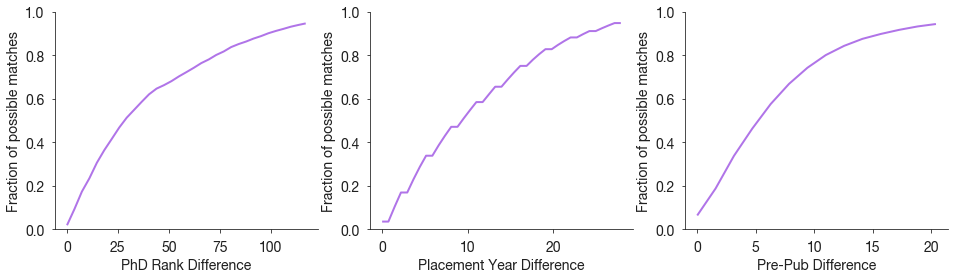

In [5]:
fig, axs = plt.subplots(1,3, figsize=(16, 4))

labels = ['PhD Rank Difference', 'Placement Year Difference', 'Pre-Pub Difference']

for a, ax in enumerate(axs):
    dimension = a 
    distances = []
    num_profiles = len(profiles)

    for i in xrange(num_profiles):
        for j in xrange(i+1, num_profiles):
            distances.append(np.abs(profiles[i,dimension]-profiles[j,dimension]))

    distances = np.array(distances)
    min_dist = np.min(distances)
    max_dist = np.max(distances)
    rng_dist = np.linspace(min_dist, max_dist)
    denom = float(len(distances))

    curve = np.array([len(np.where(distances <= c)[0])/denom for c in rng_dist])
    keep = np.min(np.where(curve >= 0.95)[0])

    ax.plot(rng_dist[:keep], curve[:keep], color=ACCENT_COLOR_1, lw=LINE_WIDTH)
    finalize(ax)

    ax.set_ylabel('Fraction of possible matches')
    ax.set_ylim(0,1)
    ax.set_xlabel(labels[a])

plt.show()

#### For a set of specific caliper distances, how many matches can we make?

In [6]:
calipers = [5, 1, 1, 0]  # PhD rank, Placement Year, Pre-hire pubs, Gender (0=Male)
A = np.zeros((num_profiles, num_profiles), dtype=float)

for i in xrange(num_profiles):
    for j in xrange(i+1, num_profiles):
        diff = np.abs(profiles[i]-profiles[j])
        good = True
        for c, caliper in enumerate(calipers):
            if diff[c] > caliper:
                good = False
                break
                
        if good:
            A[i,j] = 1
print "Can make N=%d matches. (%.2f%% of all possible)" % (A.sum(), 100 * A.sum() / ((num_profiles*(num_profiles-1))/2))

Can make N=2522 matches. (0.12% of all possible)


In [7]:
def draw_matches(adjacency_matrix):
    matches = []
    A = adjacency_matrix.copy()
    
    while A.sum() > 0:
        rows, cols = np.where(A > 0)
        idx = np.random.choice(xrange(len(rows)))
        a, b = rows[idx], cols[idx]
        matches.append((a, b))
        A[a,:] = 0
        A[:,a] = 0
        A[b,:] = 0
        A[:,b] = 0
    
    return matches

In [8]:
matches = draw_matches(A)
num_matches = float(len(matches))
print 'Made %d matches.' % (num_matches)

Made 624 matches.


In [9]:
count = 0.
total = 0.
diffs = []

for a, b in matches: 
    person_a = profiled_faculty[a]
    person_b = profiled_faculty[b]
    higher = np.argmin([cs_inst[person_a.first_asst_job_location]['pi'], cs_inst[person_b.first_asst_job_location]['pi']])
    prolif = np.argmax([person_a.post_pubs, person_b.post_pubs])
    
    if higher == 0: # Person A placed higher
        diffs.append(person_a.post_pubs - person_b.post_pubs)
    else:
        diffs.append(person_b.post_pubs - person_a.post_pubs)
    
    if higher == prolif:
        count += 1
    total += 1
    
print 'fraction:', count/total
print 'pvalue:', sp.stats.binom_test(count, total, 0.5, alternative='greater')

fraction: 0.592948717949
pvalue: 1.95363577627e-06


In [10]:
count = 0.
total = 0.
diffs = []

for a, b in matches: 
    person_a = profiled_faculty[a]
    person_b = profiled_faculty[b]
    
    if not person_a.is_female and not person_b.is_female:
        higher = np.argmin([cs_inst[person_a.first_asst_job_location]['pi'], cs_inst[person_b.first_asst_job_location]['pi']])
        prolif = np.argmax([person_a.post_pubs, person_b.post_pubs])

        if higher == 0: # Person A placed higher
            diffs.append(person_a.post_pubs - person_b.post_pubs)
        else:
            diffs.append(person_b.post_pubs - person_a.post_pubs)

        if higher == prolif:
            count += 1
        total += 1
    
print 'total:', total
print 'fraction:', count/total
print 'pvalue:', sp.stats.binom_test(count, total, 0.5, alternative='greater')

total: 570.0
fraction: 0.589473684211
pvalue: 1.11265522065e-05


In [11]:
count = 0.
total = 0.
diffs = []

for a, b in matches: 
    person_a = profiled_faculty[a]
    person_b = profiled_faculty[b]
    
    if person_a.is_female and person_b.is_female:
        higher = np.argmin([cs_inst[person_a.first_asst_job_location]['pi'], cs_inst[person_b.first_asst_job_location]['pi']])
        prolif = np.argmax([person_a.post_pubs, person_b.post_pubs])

        if higher == 0: # Person A placed higher
            diffs.append(person_a.post_pubs - person_b.post_pubs)
        else:
            diffs.append(person_b.post_pubs - person_a.post_pubs)

        if higher == prolif:
            count += 1
        total += 1
    
print 'total:', total
print 'fraction:', count/total
print 'pvalue:', sp.stats.binom_test(count, total, 0.5, alternative='greater')

total: 54.0
fraction: 0.62962962963
pvalue: 0.0379523647446


*** Sanity check #1 *** – how often is it the case that the person who started out more productive ended up being more productive in the long run?

In [12]:
count = 0.
total = 0.
diffs = []

for a, b in matches: 
    person_a = profiled_faculty[a]
    person_b = profiled_faculty[b]
    
    # Skip if they have exactly the same number of publications before or after
    if person_a.pre_pubs == person_b.pre_pubs or person_a.post_pubs == person_b.post_pubs:
        continue
    
    higher = np.argmax([person_a.pre_pubs, person_b.pre_pubs])
    prolif = np.argmax([person_a.post_pubs, person_b.post_pubs])
    
    if higher == 0: # Person A placed higher
        diffs.append(person_a.post_pubs - person_b.post_pubs)
    else:
        diffs.append(person_b.post_pubs - person_a.post_pubs)
    
    if higher == prolif:
        count += 1
    total += 1
    
print 'fraction:', count/total
print 'pvalue:', sp.stats.binom_test(count, total, 0.5, alternative='greater')
print 'N=%d (%.1f%% of total)' % (int(total), 100.*total/num_matches)

fraction: 0.490099009901
pvalue: 0.672812453869
N=404 (64.7% of total)


*** Sanity check #2 *** – how often is it the case that the person who trained at the more prestigious location also went on to become more productive?

In [13]:
count = 0.
total = 0.
diffs = []

for a, b in matches: 
    person_a = profiled_faculty[a]
    person_b = profiled_faculty[b]
    
    # Skip if they have exactly the same rank, num pubs
    if person_a.phd_rank == person_b.phd_rank or person_a.post_pubs == person_b.post_pubs:
        continue
    
    higher = np.argmin([person_a.phd_rank, person_b.phd_rank])
    prolif = np.argmax([person_a.post_pubs, person_b.post_pubs])
    
    if higher == 0: # Person A placed higher
        diffs.append(person_a.post_pubs - person_b.post_pubs)
    else:
        diffs.append(person_b.post_pubs - person_a.post_pubs)
    
    if higher == prolif:
        count += 1
    total += 1
    
print 'fraction:', count/total
print 'pvalue:', sp.stats.binom_test(count, total, 0.5, alternative='greater')
print 'N=%d (%.1f%% of total)' % (int(total), 100.*total/num_matches)

fraction: 0.503968253968
pvalue: 0.446855939699
N=504 (80.8% of total)


*** Sanity check #3 *** – How often is it the case that the person who placed later was more productive?

In [14]:
count = 0.
total = 0.
diffs = []

for a, b in matches: 
    person_a = profiled_faculty[a]
    person_b = profiled_faculty[b]
    
    # Skip if they have exactly the same start year, num pubs
    if person_a.first_asst_job_year == person_b.first_asst_job_year or person_a.post_pubs == person_b.post_pubs:
        continue
    
    higher = np.argmax([person_a.first_asst_job_year, person_b.first_asst_job_year])
    prolif = np.argmax([person_a.post_pubs, person_b.post_pubs])
    
    if higher == 0: # Person A placed higher
        diffs.append(person_a.post_pubs - person_b.post_pubs)
    else:
        diffs.append(person_b.post_pubs - person_a.post_pubs)
    
    if higher == prolif:
        count += 1
    total += 1
    
print 'fraction:', count/total
print 'pvalue:', sp.stats.binom_test(count, total, 0.5, alternative='two-sided')
print 'N=%d (%.1f%% of total)' % (int(total), 100.*total/num_matches)

fraction: 0.491002570694
pvalue: 0.76101156185
N=389 (62.3% of total)


## Recreating Allison & Long's Figure

Back in 1990 Allison & Long wrote an excellent paper titled "Departmental Effects on Scientific Productivity," which includes the figure shown below. In their paper A+L were looking at mid-career transitions, rather than initial placement, and they were averaging productivity trajectories for people who shot up or down the rankings. I think this is a really compelling figure, so I'd like to do something similar using our data.

<img src="figures/Allison90.png">

In [15]:
rank_changes = []
threshold = 20
upward = []
downward = []

for person in cs_faculty:
    rank_change = cs_inst[person.phd_location]['pi'] \
                - cs_inst[person.first_asst_job_location]['pi']
    # Note: most rank changes will be negative (people tend to place down)
    
    if np.abs(rank_change) >= threshold:
        if rank_change > 0:
            upward.append(person)
        else:
            downward.append(person)
            
print '%d people moving UP by at least %.1f' % (len(upward), threshold)
print '%d people moving DOWN by at least %.1f' % (len(downward), threshold)

94 people moving UP by at least 20.0
1662 people moving DOWN by at least 20.0


In [16]:
years = np.arange(-Npre, Npost+1)  # Years relative to initial start date
upward_pub_counts = {y:[] for y in years}
downward_pub_counts = {y:[] for y in years}

for (people, counts) in [(upward, upward_pub_counts), (downward, downward_pub_counts)]:
    for person in people:
        start_year = person.first_asst_job_year
        temp_counts = Counter()
        
        if 'dblp_pubs' not in person:
            continue

        for pub in person.dblp_pubs:
            if pub['pub_type'] in ['inproceedings', 'article'] and pub['year'] is not None:
                    if pub['year'] <= start_year and pub['year'] >= start_year - Npre:
                        temp_counts[pub['year']-start_year] += adjust(pub['year'])
                    elif pub['year'] > start_year and pub['year'] <= start_year + Npost:
                        temp_counts[pub['year']-start_year] += adjust(pub['year'])

        upper = np.min([2011-start_year, Npost])
        for i in xrange(-Npre, upper+1):
            counts[i].append(temp_counts[i])
            
upward_traj = np.array([np.mean(upward_pub_counts[i]) for i in years])
upward_std =  np.array([np.std(upward_pub_counts[i]) for i in years])
upward_size = np.array([len(upward_pub_counts[i]) for i in years])
downward_traj = np.array([np.mean(downward_pub_counts[i]) for i in years])
downward_std  = np.array([np.std(downward_pub_counts[i]) for i in years])
downward_size = np.array([len(downward_pub_counts[i]) for i in years])

z_critical = stats.norm.ppf(q = 0.975)
upward_margin = z_critical * (upward_std/np.sqrt(upward_size))        # Margin of error (up)
downward_margin = z_critical * (downward_std/np.sqrt(downward_size))  # Margin of error (down)

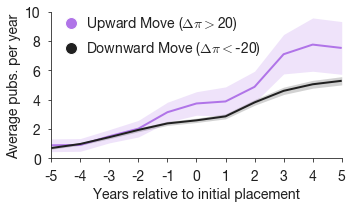

In [17]:
fig, ax = plt.subplots(1,1,figsize=(5,3))

ax.fill_between(years, upward_traj-upward_margin, upward_traj+upward_margin,
                color=ACCENT_COLOR_1, alpha=0.2, lw=0)
ax.fill_between(years, downward_traj-downward_margin, downward_traj+downward_margin,
                color=ALMOST_BLACK, alpha=0.2, lw=0)

ax.plot(years, upward_traj, color=ACCENT_COLOR_1, lw=LINE_WIDTH)
ax.plot(years, downward_traj, color=ALMOST_BLACK, lw=LINE_WIDTH)

ax.set_xlabel('Years relative to initial placement')
ax.set_ylabel('Average pubs. per year')
ax.set_xticks(years)

ylims = ax.get_ylim()
pad = 0.
#ax.plot([pad,pad], [ylims[1], 0], '--', color=ALMOST_BLACK, lw=1, zorder=-10)
#if pad > 0:
#    ax.plot([-pad,-pad], [ylims[1], 0], '--', color=ALMOST_BLACK, lw=1, zorder=-10)
ax.set_ylim(0, 10)
ax.set_xlim(np.min(years), np.max(years))

fake_line_1 = Line2D(range(1), range(1), color=ACCENT_COLOR_1, marker='o',markersize=12, linestyle='None', markeredgecolor='w')
fake_line_2 = Line2D(range(1), range(1), color=ALMOST_BLACK, marker='o',markersize=12, linestyle='None', markeredgecolor='w')
leg = ax.legend((fake_line_1,fake_line_2),(r'Upward Move ($\Delta\pi>$20)',r'Downward Move ($\Delta\pi<$-20)'), numpoints=1, loc=(0, .65), 
                 frameon=False, fontsize=LABEL_SIZE, labelspacing=0.5, handletextpad=0.1)

finalize(ax)
plt.tight_layout()
plt.savefig(FIGS_DIR + NOTEBOOK_ID + 'mean_pubs_placement.pdf')
plt.show()

## Google Scholar Information

In [18]:
either = 0.
both = 0.
missing = 0.

for a, b in matches:
    gs_a = 'gs' in profiled_faculty[a]
    gs_b = 'gs' in profiled_faculty[b]
    
    either += int(gs_a or gs_b)
    both += int(gs_a and gs_b)
    missing += int(not gs_a) + int(not gs_b)
    
"""    # To print "low-hanging fruit" (one match-pair for every linked GS profile)
    if not gs_a and not gs_b:
        if not gs_a:
            print '%s\t%s' % (cs_faculty[a].facultyName, cs_faculty[a].place)
            print '%s\t%s' % (cs_faculty[b].facultyName, cs_faculty[b].place)
            print 
"""

print 'Either has  :', either / float(len(matches))
print 'Both have   :', both / float(len(matches))
print 'Num missing :', int(missing)

Either has  : 0.849358974359
Both have   : 0.432692307692
Num missing : 448
